In [57]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from scipy import stats
import statsmodels.api as sm

import lmoments3 as lm
from lmoments3 import distr as ldistr

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

In [2]:
ds = xr.open_dataset('./data/ERA5-WRF_45km_monthly.nc')
ds

<xarray.Dataset>
Dimensions:            (time: 852, y: 104, x: 109)
Coordinates:
  * time               (time) datetime64[ns] 1950-09-01 ... 2021-08-01
    Lambert_Conformal  int32 ...
    lakemask           (y, x) float32 ...
    landmask           (y, x) float32 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
  * x                  (x) float64 -6.285e+06 -6.24e+06 ... -1.47e+06 -1.425e+06
  * y                  (y) float64 -1.126e+06 -1.081e+06 ... 3.464e+06 3.509e+06
Data variables:
    T2                 (time, y, x) float32 ...

In [3]:
ds['T2'].data = (ds['T2'].data - 273.15) * (9/5) + 32
ds['T2'].attrs['units'] = 'F'

In [4]:
da = ds['T2']

In [5]:
stations = pd.read_csv('./data/weather_stations.csv')
stations.tail()

STATE                        STATION        CITY   FAA     LAT_Y      LON_X
27    CA  LANCASTER WILLIAM J FOX FIELD   LANCASTER  KWJF  34.74121 -118.21255
28    CA               ARCATA EUREKA AP      ARCATA  KACV  40.97844 -124.10479
29    CA     SACRAMENTO METROPOLITAN AP  SACRAMENTO  KSMF  38.70069 -121.59479
30    CA                    STOCKTON AP    STOCKTON  KSCK  37.88997 -121.22637
31    CA                     REDDING AP     REDDING  KRDD  40.51462 -122.29773

In [6]:
lons = stations.LON_X[0]
lats = stations.LAT_Y[0]

In [7]:
# pull projection values from netcdf file
projection = ccrs.LambertConformal(central_longitude=-70,
                             central_latitude=38,
                             standard_parallels=[30., 60.])

#function to transform points accordingly
transform = np.vectorize(lambda x, y: projection.transform_point(x, y, ccrs.PlateCarree()))

desired_x, desired_y = transform(lons, lats)

In [8]:
da_stations = da.sel(x=desired_x, y=desired_y, method='nearest')
print(da_stations)

<xarray.DataArray 'T2' (time: 852)>
array([68.29229 , 64.532715, 59.219284, 54.272583, 47.408764, 51.498642,
       53.98172 , 57.667137, 63.60492 , 67.48507 , 73.79754 , 71.87328 ,
       71.37494 , 61.291912, 55.185436, 44.826866, 44.12984 , 50.02664 ,
       47.859314, 58.25331 , 66.9769  , 63.231987, 74.74527 , 72.94253 ,
       72.47984 , 62.914867, 51.73507 , 47.241497, 50.911316, 50.461807,
       52.737957, 55.91619 , 58.195305, 65.98022 , 78.612625, 70.62084 ,
       71.25261 , 61.986084, 56.174866, 49.7238  , 46.519203, 55.755684,
       50.495155, 61.452644, 66.45851 , 69.142685, 78.46651 , 69.78478 ,
       69.93359 , 60.781433, 56.054512, 46.796   , 43.369476, 48.72306 ,
       53.792038, 54.55191 , 62.382854, 67.512695, 72.05725 , 76.648605,
       72.025055, 61.934227, 51.666847, 49.43882 , 48.571503, 44.92036 ,
       54.018578, 56.76181 , 62.875427, 70.62178 , 72.8208  , 70.2834  ,
       71.69975 , 58.18454 , 56.724403, 50.59733 , 43.966145, 52.149364,
       53.46085

In [9]:
ams = da_stations.groupby('time.year').max('time')

In [10]:
lmom_gev = distr.gev.lmom_fit(ams)
lmom_gev

OrderedDict([('c', 0.35492408681465815),
             ('loc', 75.27721455138726),
             ('scale', 2.290334288706858)])

In [11]:
fit_gev = stats.genextreme(**lmom_gev)
fit_gev

In [12]:
return_year = 10
return_period = 1.0-(1./return_year)
return_value = fit_gev.ppf(return_period)
return_value

78.82696489095808

In [13]:
return_periods  = [2, 5, 10, 20, 30, 40, 50]

return_intervals = np.empty(len(return_periods))

for i in range(len(return_periods)):
    return_intervals[i] = 1.0-(1.0 / return_periods[i])
    
values = fit_gev.ppf(return_intervals)

pd.DataFrame({'return_periods': return_periods, 'values': values}, 
             columns=['return_periods', 'values'])

return_periods     values
0               2  76.064345
1               5  77.940929
2              10  78.826965
3              20  79.481534
4              30  79.788894
5              40  79.979987
6              50  80.114720

In [14]:
ks = [('GEV', stats.kstest(ams, 'genextreme', 
             args=(lmom_gev['c'], lmom_gev['loc'], lmom_gev['scale'])))]

labels = ['distribution', 'KS (statistics, pvalue)']
pd.DataFrame(ks, columns=labels)

distribution                    KS (statistics, pvalue)
0          GEV  (0.04706328334932973, 0.9950410481091314)

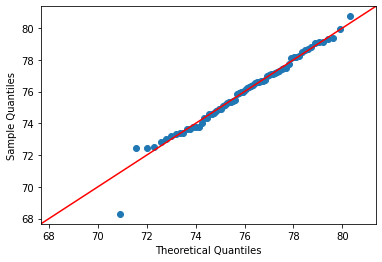

In [15]:
sm.qqplot(ams, stats.genextreme, distargs= (lmom_gev['c'],), loc=lmom_gev['loc'], scale=lmom_gev['scale'], line='45');

In [32]:
def bootstrap(ams):
    
    sample_size = len(ams)
    
    new_ams = np.random.choice(ams, size=sample_size, replace=True)
    
    lmom_gev = distr.gev.lmom_fit(new_ams)
    fit_gev = stats.genextreme(**lmom_gev)
    
    return_period = 1.0-(1./return_year)
    result = fit_gev.ppf(return_period)
    
    return result

In [33]:
value = []
return_year = 10

for _ in range(1000):
    
    result = bootstrap(ams)

    value.append(result)
    
value_np = xr.DataArray(value)

(array([  3.,   7.,  36., 106., 247., 269., 197., 103.,  27.,   5.]),
 array([77.66910013, 77.87628224, 78.08346435, 78.29064646, 78.49782857,
        78.70501069, 78.9121928 , 79.11937491, 79.32655702, 79.53373913,
        79.74092124]),
 <BarContainer object of 10 artists>)

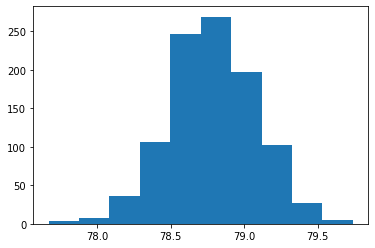

In [34]:
plt.hist(value_np.values)

In [35]:
return_year=10
return_period = 1.0-(1./return_year)

fit_gev.ppf(return_period)

78.82696489095808

In [36]:
conf_int = np.percentile(value_np, [2.5,97.5])
conf_int

array([78.22348295, 79.34622839])

# building functions

In [45]:
ds = xr.open_dataset('./data/ERA5-WRF_45km_monthly.nc')

In [46]:
ds['T2'].data = (ds['T2'].data - 273.15) * (9/5) + 32

da = ds['T2']
da.attrs['model'] = 'ERA5-WRF'
da.attrs['resolution'] = '45km'
da.attrs['T2 units'] = 'F'

In [47]:
stations = pd.read_csv('./data/weather_stations.csv')
stations.head()

station_lon = stations.LON_X[0]
station_lat = stations.LAT_Y[0]

In [48]:
# pull projection values from file

projection = ccrs.LambertConformal(central_longitude=-70,
                             central_latitude=38,
                             standard_parallels=[30., 60.])

#function to transform points accordingly

transform = np.vectorize(lambda x, y: projection.transform_point(x, y, ccrs.PlateCarree()))

desired_x, desired_y = transform(station_lon, station_lat)

In [49]:
da_station = da.sel(x=desired_x, y=desired_y, method='nearest')

In [50]:
def get_ams(da, extremes_type='max'):
    
    extremes_types = ['max']
    if extremes_type not in extremes_types:
        raise ValueError('invalid extremes type. expected one of the following: %s' % extremes_types)
    
    if extremes_type == 'max':
        ams = da.resample(time='A').max(keep_attrs=True)
        ams.attrs['extreme value extraction method'] = 'block maxima'
        ams.attrs['extremes type'] = 'maxima'
        ams.attrs['block size'] = '1 year'
        ams.attrs['timeseries type'] = 'annual max series'
    
    # if extremes_type == 'min':
    #     ams = da.resample(time='A').min(keep_attrs=True)
    #     ams.attrs['extreme value extraction method'] = 'block maxima'
    #     ams.attrs['extremes type'] = 'minima'
    #     ams.attrs['block size'] = '1 year'
    #     ams.attrs['timeseries type'] = 'annual min series'
    
    return ams

In [51]:
ams_station = get_ams(da_station, extremes_type='max')
ams_station

<xarray.DataArray 'T2' (time: 72)>
array([68.29228973, 73.79753876, 74.74526978, 78.61262512, 78.46650696,
       76.64860535, 72.82080078, 75.35688782, 76.7131958 , 77.50630188,
       76.59883118, 77.13040161, 74.34559631, 73.66537476, 74.65765381,
       73.00668335, 75.3795166 , 79.03439331, 76.11219788, 77.43225098,
       77.18929291, 75.93322754, 76.29237366, 74.04917908, 74.58361053,
       72.47462463, 72.43325806, 75.17791748, 73.36813354, 73.63549042,
       77.12068176, 77.0438385 , 74.30488586, 75.45137024, 79.33728027,
       79.14529419, 77.23983002, 73.32781982, 78.25430298, 75.97085571,
       77.32492065, 75.11639404, 77.46614838, 72.5146637 , 76.63223267,
       76.54533386, 78.10121155, 73.74523926, 78.16674805, 73.22125244,
       75.28327942, 74.90419006, 75.82336426, 78.19366455, 74.57141113,
       78.68963623, 80.74446869, 74.88479614, 76.37844849, 76.42277527,
       73.41581726, 73.78155518, 77.74190521, 76.65343475, 75.98436737,
       75.34688568, 76.23013306, 79.93493652, 79.14573669, 76.96434784,
       79.35744476, 78.8163147 ])
Coordinates:
  * time               (time) datetime64[ns] 1950-12-31 ... 2021-12-31
    Lambert_Conformal  int32 ...
    lakemask           float32 ...
    landmask           float32 ...
    lat                float32 ...
    lon                float32 ...
    x                  float64 -4.08e+06
    y                  float64 1.034e+06
Attributes:
    model:                            ERA5-WRF
    resolution:                       45km
    T2 units:                         F
    extreme value extraction method:  block maxima
    extremes type:                    maxima
    block size:                       1 year
    timeseries type:                  annual max series

In [52]:
def bootstrap(ams, distr='gev', data_variable='return_value', arg_value=10):
    
    distrs = ['gev', 'gumbel', 'weibull', 'pearson3', 'genpareto']
    if distr not in distrs:
        raise ValueError("invalid distr type. expected one of the following: %s" % distrs)
        
    data_variables = ['return_value', 'return_prob', 'return_period']
    if data_variable not in data_variables:
        raise ValueError("invalid data variable type. expected one of the following: %s" % data_variables)
    
    sample_size = len(ams)
    new_ams = np.random.choice(ams, size=sample_size, replace=True)
    
    if distr == 'gev':
        try:
            lmoments = ldistr.gev.lmom_fit(new_ams)
            fitted_distr = stats.genextreme(**lmoments)
            
            if data_variable == 'return_value':
                return_event = 1.0-(1./arg_value)
                return_value = fitted_distr.ppf(return_event)
                result = round(return_value, 5)
                    
            elif data_variable == 'return_prob':
                result = 1-(fitted_distr.cdf(arg_value))
                
            elif data_variable == 'return_period':
                return_prob = fitted_distr.cdf(arg_value)
                if return_prob == 1.0:
                    result = np.nan
                else:
                    return_period = -1.0/(return_prob-1.0)
                    result = round(return_period, 3)
                    
        except ValueError:
            result = np.nan

    if distr == 'gumbel':
        try:
            lmoments = ldistr.gum.lmom_fit(new_ams)
            fitted_distr = stats.gumbel_r(**lmoments)
            
            if data_variable == 'return_value':
                return_event = 1.0-(1./arg_value)
                return_value = fitted_distr.ppf(return_event)
                result = round(return_value, 5)
                    
            elif data_variable == 'return_prob':
                result = 1-(fitted_distr.cdf(arg_value))
                
            elif data_variable == 'return_period':
                return_prob = fitted_distr.cdf(arg_value)
                if return_prob == 1.0:
                    result = np.nan
                else:
                    return_period = -1.0/(return_prob-1.0)
                    result = round(return_period, 3)
                    
        except ValueError:
            result = np.nan

    if distr == 'weibull':
        try:
            lmoments = ldistr.wei.lmom_fit(new_ams)
            fitted_distr = stats.weibull_min(**lmoments)
            
            if data_variable == 'return_value':
                return_event = 1.0-(1./arg_value)
                return_value = fitted_distr.ppf(return_event)
                result = round(return_value, 5)
                    
            elif data_variable == 'return_prob':
                result = 1-(fitted_distr.cdf(arg_value))
                
            elif data_variable == 'return_period':
                return_prob = fitted_distr.cdf(arg_value)
                if return_prob == 1.0:
                    result = np.nan
                else:
                    return_period = -1.0/(return_prob-1.0)
                    result = round(return_period, 3)
                    
        except ValueError:
            result = np.nan

    if distr == 'pearson3':
        try:
            lmoments = ldistr.pe3.lmom_fit(new_ams)
            fitted_distr = stats.pearson3(**lmoments)
            
            if data_variable == 'return_value':
                return_event = 1.0-(1./arg_value)
                return_value = fitted_distr.ppf(return_event)
                result = round(return_value, 5)
                    
            elif data_variable == 'return_prob':
                result = 1-(fitted_distr.cdf(arg_value))
                
            elif data_variable == 'return_period':
                return_prob = fitted_distr.cdf(arg_value)
                if return_prob == 1.0:
                    result = np.nan
                else:
                    return_period = -1.0/(return_prob-1.0)
                    result = round(return_period, 3)
                    
        except ValueError:
            result = np.nan

    if distr == 'genpareto':
        try:
            lmoments = ldistr.gpa.lmom_fit(new_ams)
            fitted_distr = stats.genpareto(**lmoments)
            
            if data_variable == 'return_value':
                return_event = 1.0-(1./arg_value)
                return_value = fitted_distr.ppf(return_event)
                result = round(return_value, 5)
                    
            elif data_variable == 'return_prob':
                result = 1-(fitted_distr.cdf(arg_value))
                
            elif data_variable == 'return_period':
                return_prob = fitted_distr.cdf(arg_value)
                if return_prob == 1.0:
                    result = np.nan
                else:
                    return_period = -1.0/(return_prob-1.0)
                    result = round(return_period, 3)
                    
        except ValueError:
            result = np.nan
    
    return result

In [90]:
def get_return_value(ams, return_period=10, distr='gev', 
                     multiple_points=True, bootstrap_runs=1000,
                    conf_int_lower_bound=2.5, conf_int_upper_bound=97.5):
    
    distrs = ['gev', 'gumbel', 'weibull', 'pearson3', 'genpareto']
    if distr not in distrs:
        raise ValueError("invalid distr type. expected one of the following: %s" % distrs)
        
    ams_attributes = ams.attrs
    
    
    if multiple_points == True:
        ams = ams.stack(allpoints=['x','y']).squeeze().groupby('allpoints')
    
    def apply_function(ams):
    
        def function(ams):
            
            if distr == 'gev':
                try:
                    lmoments = ldistr.gev.lmom_fit(ams)
                    fitted_distr = stats.genextreme(**lmoments)
                    return_event = 1.0-(1./return_period)
                    return_value = fitted_distr.ppf(return_event)
                    return_value = round(return_value, 5)
                except ValueError:
                    return_value = np.nan
                    
                bootstrap_values = []
                data_variable = 'return_value'
                for _ in range(bootstrap_runs):
                    result = bootstrap(ams, distr=distr, data_variable='return_value', arg_value=return_period)
                    bootstrap_values.append(result)
                conf_int_array = np.percentile(bootstrap_values, [conf_int_lower_bound, 
                                                            conf_int_upper_bound])
                conf_int = tuple(conf_int_array)
                
            if distr == 'gumbel':
                try:
                    lmoments = ldistr.gum.lmom_fit(ams)
                    fitted_distr = stats.gumbel_r(**lmoments)
                    return_event = 1.0-(1./return_period)
                    return_value = fitted_distr.ppf(return_event)
                    return_value = round(return_value, 5)
                except ValueError:
                    return_value = np.nan
                
                bootstrap_values = []
                data_variable = 'return_value'
                for _ in range(bootstrap_runs):
                    result = bootstrap(ams, distr=distr, data_variable='return_value', arg_value=return_period)
                    bootstrap_values.append(result)
                conf_int_array = np.percentile(bootstrap_values, [conf_int_lower_bound, 
                                                            conf_int_upper_bound])
                conf_int = tuple(conf_int_array)
                
            if distr == 'weibull':
                try:
                    lmoments = ldistr.wei.lmom_fit(ams)
                    fitted_distr = stats.weibull_min(**lmoments)
                    return_event = 1.0-(1./return_period)
                    return_value = fitted_distr.ppf(return_event)
                    return_value = round(return_value, 5)
                except ValueError:
                    return_value = np.nan
                bootstrap_values = []
                data_variable = 'return_value'
                for _ in range(bootstrap_runs):
                    result = bootstrap(ams, distr=distr, data_variable='return_value', arg_value=return_period)
                    bootstrap_values.append(result)
                conf_int_array = np.percentile(bootstrap_values, [conf_int_lower_bound, 
                                                            conf_int_upper_bound])
                conf_int = tuple(conf_int_array)
                
            if distr == 'pearson3':
                try:
                    lmoments = ldistr.pe3.lmom_fit(ams)
                    fitted_distr = stats.pearson3(**lmoments)
                    return_event = 1.0-(1./return_period)
                    return_value = fitted_distr.ppf(return_event)
                    return_value = round(return_value, 5)
                except ValueError:
                    return_value = np.nan
                bootstrap_values = []
                data_variable = 'return_value'
                for _ in range(bootstrap_runs):
                    result = bootstrap(ams, distr=distr, data_variable='return_value', arg_value=return_period)
                    bootstrap_values.append(result)
                conf_int_array = np.percentile(bootstrap_values, [conf_int_lower_bound, 
                                                            conf_int_upper_bound])
                conf_int = tuple(conf_int_array)
            
            if distr == 'genpareto':
                try:
                    lmoments = ldistr.gpa.lmom_fit(ams)
                    fitted_distr = stats.genpareto(**lmoments)
                    return_event = 1.0-(1./return_period)
                    return_value = fitted_distr.ppf(return_event)
                    return_value = round(return_value, 5)
                except ValueError:
                    return_value = np.nan
                bootstrap_values = []
                data_variable = 'return_value'
                for _ in range(bootstrap_runs):
                    result = bootstrap(ams, distr=distr, data_variable='return_value', arg_value=return_period)
                    bootstrap_values.append(result)
                conf_int_array = np.percentile(bootstrap_values, [conf_int_lower_bound, 
                                                            conf_int_upper_bound])
                conf_int = tuple(conf_int_array)

            return return_value, conf_int
    
        return xr.apply_ufunc(function, ams, input_core_dims=[["time"]], 
                          exclude_dims=set(("time",)), output_core_dims=[[],[]])
    
    return_value, conf_int = apply_function(ams)
    
    return_value = return_value.rename('return_value')
    new_ds = return_value.to_dataset()
    new_ds['conf_int'] = conf_int
    
    if multiple_points == True:
        new_ds = new_ds.unstack('allpoints')
        
    new_ds['return_value'].attrs['return period'] = '1 in {} year event'.format(str(return_period))
    new_ds['conf_int'].attrs['confidence interval bounds'] = '({}th percentile, {}th percentile)'.format(str(conf_int_lower_bound), str(conf_int_upper_bound))
    new_ds.attrs = ams_attributes
    new_ds.attrs['distribution'] = '{}'.format(str(distr))
    
    return new_ds